### Plan of Action
🧠 Step-by-Step Pipeline: Generalized Model + EA + XGBoost
1. Data Preparation
- Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)
- Normalize features per ticker (z-score or min-max scaling)
- Add metadata: ticker_id, sector, day_of_week, macro regime (optional)
- Create rolling windows for time series modeling (e.g., 10-day sequences)
2. Feature Engineering
- Technical indicators: RSI, MACD, Bollinger Bands, ATR
- Candle features: range, body size, wick ratios
- Volume features: OBV, VWAP, volume spikes
- Lagged returns, volatility, momentum scores
3. Labeling Strategy
- Define swing trade targets:
- Binary: Will price rise >x% in next n days?
- Multi-class: Uptrend / Downtrend / Sideways
- Regression: Expected return over next n days

🧬 4. Evolutionary Algorithm Optimization
- Purpose: Explore feature combinations, thresholds, and model hyperparameters
- Approach:
- Use genetic algorithm (e.g., DEAP, PyGAD) to evolve:
- Feature subsets
- Thresholds for entry/exit
- XGBoost hyperparameters (e.g., depth, learning rate)
- Fitness function: Sharpe ratio, accuracy, precision, or custom KPI
# Example fitness function
def fitness(individual):
    selected_features = individual[:n]
    xgb_params = decode_params(individual[n:])
    model = XGBClassifier(**xgb_params)
    score = cross_val_score(model, X[selected_features], y, scoring='accuracy')
    return score.mean(),



🌲 5. XGBoost Refinement
- Train final model using best EA-selected features and hyperparameters
- Use XGBoost for:
- Feature importance ranking
- Fast inference
- Robust performance on tabular data
from xgboost import XGBClassifier
model = XGBClassifier(**best_params)
model.fit(X_train[selected_features], y_train)



📊 6. Evaluation & Backtesting
- Use walk-forward validation or time-series cross-validation
- Evaluate:
- Accuracy, precision, recall
- Sharpe ratio, Sortino ratio
- Win rate, average trade duration


# 0. Dependencies

In [48]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator

## 1. Data Preparation
### Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)

Core Equity Holdings (NN Group, 2025)
- "AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK"

ETF Additions (for sector/macro exposure)
- "SPY", "TLT", "LQD", "VNQ", "XLV"


Description:
- Amazon.com Inc – Consumer Discretionary
- Meta Platforms Inc – Communication Services
- Broadcom Inc – Technology
- Eli Lilly & Co – Healthcare
- Eaton Corp PLC – Industrials
- CyberArk Software Ltd – Technology
- Linde PLC – Materials
- Waste Management Inc – Industrials
- Soleno Therapeutics Inc – Healthcare
- Cytokinetics Inc – Healthcare
- SPDR S&P 500 ETF (SPY) – Broad Market ETF
- iShares 20+ Year Treasury ETF (TLT) – Government Bonds
- iShares Investment Grade Corporate Bond ETF (LQD) – Corporate Bonds
- Vanguard Real Estate ETF (VNQ) – Real Estate
- Health Care Select Sector SPDR ETF (XLV) – Healthcare Sector ETF

Based on Q2 2025 of Nationale-Nederlanden Powszechne Towarzystwo Emerytalne S.A.
https://www.sensamarket.com/institutional-investor/000201108125000008/compare/000201108125000005

In [49]:
tickers = ["AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK", "SPY", "TLT", "LQD", "VNQ", "XLV"]
leadup_days = 0
start_date = (datetime.strptime("2015-01-01", "%Y-%m-%d") - timedelta(days=leadup_days)).strftime("%Y-%m-%d")
raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")

C:\Users\DLinger\AppData\Local\Temp\ipykernel_19772\4254150672.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")
[*********************100%***********************]  15 of 15 completed


In [50]:
raw_data

Ticker             LLY                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2015-01-02   57.322866   58.185547   57.281790   57.561131  3146200   
2015-01-05   57.290023   57.585793   56.813495   56.994247  4845500   
2015-01-06   57.446128   58.259514   56.854576   57.281811  5127400   
2015-01-07   57.536482   57.947281   56.238356   56.879208  9043000   
2015-01-08   57.511835   58.736014   57.232495   58.226627  7472200   
...                ...         ...         ...         ...      ...   
2024-12-24  786.664545  793.006614  782.419914  790.938965  1165400   
2024-12-26  789.398190  799.129958  786.793774  789.418091  1274200   
2024-12-27  785.302712  788.583078  774.586780  778.513306  2096500   
2024-12-30  773.294589  775.123675  766.415751  769.238892  1719100   
2024-12-31  766.415675  769.308346  759.755501  767.409729  2327000   

Ticker             ETN                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2015-01-02   52.713593   52.852334   51.634501   52.359035  1638100  ...   
2015-01-05   51.726995   51.750117   50.062109   50.193146  3206200  ...   
2015-01-06   50.170025   50.293352   48.998443   49.630482  3241700  ...   
2015-01-07   50.339586   50.539990   49.599639   49.776920  3120800  ...   
2015-01-08   50.254793   51.580534   50.254793   51.557411  3445900  ...   
...                ...         ...         ...         ...      ...  ...   
2024-12-24  335.296637  338.276578  333.831442  338.128082   507500  ...   
2024-12-26  337.444981  338.415171  335.365953  336.761871  1196500  ...   
2024-12-27  333.455234  335.464954  327.970569  331.287109  1601700  ...   
2024-12-30  325.851947  330.732690  324.267925  329.059570  1400300  ...   
2024-12-31  328.930866  330.643594  327.950765  328.554657  1134600  ...   

Ticker              WM                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2015-01-02   41.471283   41.900156   41.430824   41.875881  3140700   
2015-01-05   41.616937   41.770683   41.374179   41.455097  3859100   
2015-01-06   41.487461   41.786863   41.155691   41.487461  3010900   
2015-01-07   41.608830   41.770670   41.309429   41.519821  2243200   
2015-01-08   41.786872   42.029630   41.705954   41.997265  2941700   
...                ...         ...         ...         ...      ...   
2024-12-24  201.063432  203.219760  200.232539  203.150528   711500   
2024-12-26  202.032788  203.734118  201.884422  202.794434   736700   
2024-12-27  201.775640  203.565990  200.806267  201.805313   878700   
2024-12-30  200.014934  200.875484  199.085135  200.074280  1209700   
2024-12-31  200.272113  200.331460  198.679590  199.599487  1549000   

Ticker            SLNO                                              
Price             Open        High         Low       Close  Volume  
Date                                                                
2015-01-02  108.000000  121.800003  108.000000  112.500000      19  
2015-01-05  117.000000  131.250000  117.000000  119.849998     137  
2015-01-06  120.750000  126.750000  112.500000  126.750000      52  
2015-01-07  112.500000  123.824997  112.500000  123.000000      12  
2015-01-08  126.750000  128.250000  126.000000  127.500000      61  
...                ...         ...         ...         ...     ...  
2024-12-24   44.560001   45.009998   44.130001   44.770000  223900  
2024-12-26   44.169998   47.139999   44.169998   47.064999  415000  
2024-12-27   46.820000   47.090000   44.660000   44.820000  683400  
2024-12-30   44.040001   45.459999   43.840000   45.299999  493700  
2024-12-31   45.529999   46.000000   43.860001  

## Technical Indicators
Momentum 
- RSI
- StochRSI

Trend
- MACD
- SMA
- EMA

Volatility
- BB (Bollinger Bands)
- ATR (Average True Range)

Volume
- OBV (On-Balance Volume)
- CMF (Chaikin Money Flow)

In [51]:
def add_features(df):
    df = df.copy()
    
    # General price dynamics
    df["returns"] = df["Close"].pct_change()
    df["logReturns"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["returns"].rolling(10).std()
    df['Range'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Wick'] = df['Range'] - df['Body']

    # Momentum
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    df['StochRSI'] = StochRSIIndicator(df['Close'], window=14).stochrsi()
    
    # Short-term moving averages (faster response)
    df['SMA_10'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['EMA_10'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # Medium-term moving averages (faster than previous 50)
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = EMAIndicator(df['Close'], window=20).ema_indicator()

    # Optional: slightly faster “long-term” averages for crossovers
    df['SMA_30'] = SMAIndicator(df['Close'], window=30).sma_indicator()
    df['EMA_30'] = EMAIndicator(df['Close'], window=30).ema_indicator()

    # Faster MACD for earlier crossovers
    macd = MACD(df['Close'], window_slow=13, window_fast=6, window_sign=5)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    # Volatility
    bb = BollingerBands(df['Close'], window=20)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    
    # Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['OBV_prev'] = pd.to_numeric(df['OBV'].shift(1), errors='coerce').fillna(0).astype(int)
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], window=20).chaikin_money_flow()
    
    # Future return (5-day horizon)
    df['future_close'] = df.groupby('Ticker')['Close'].shift(-15)
    df['future_return'] = df['future_close'] / df['Close'] - 1
    df.drop(columns='future_close', inplace=True)
    
    return df

In [52]:
df_long = raw_data.stack(level=0).rename_axis(['Date', 'Ticker'])
df_long

C:\Users\DLinger\AppData\Local\Temp\ipykernel_19772\670735667.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = raw_data.stack(level=0).rename_axis(['Date', 'Ticker'])


Price                    Open        High         Low       Close    Volume
Date       Ticker                                                          
2015-01-02 AMZN     15.629000   15.737500   15.348000   15.426000  55664000
           AVGO      7.638378    7.735248    7.502154    7.574807  13500000
           CYBR     39.779999   40.599998   38.000000   38.880001    479300
           CYTK      8.010000    8.160000    7.140000    7.370000   1675600
           ETN      52.713593   52.852334   51.634501   52.359035   1638100
...                       ...         ...         ...         ...       ...
2024-12-31 SPY     584.785824  585.509524  579.343521  580.989136  57052700
           TLT      85.005689   85.150373   84.166536   84.234055  31917300
           VNQ      86.383523   86.694220   85.713580   86.490326   5045100
           WM      200.272113  200.331460  198.679590  199.599487   1549000
           XLV     135.777671  136.310590  134.998011  135.767807   6626900

[37740 rows x 5 columns]

In [53]:
results = []
for ticker, df_t in df_long.groupby('Ticker'):
    df_t = add_features(df_t.copy())
    results.append(df_t)

# Step 1: Concatenate and sort
df_processed = pd.concat(results).sort_values(['Date', 'Ticker']).copy()
df_processed = df_processed.reorder_levels(['Date', 'Ticker']).sort_index()

# Step 2: Identify last 5 rows per ticker BEFORE dropping NaNs
last_5_mask = df_processed.groupby('Ticker').tail(5).index

# Step 3: Drop NaNs EXCEPT for those in last 5 rows
df_cleaned = df_processed[~df_processed.index.isin(last_5_mask)].dropna()
df_preserved = df_processed.loc[last_5_mask]  

# Step 4: Combine and sort
df_processed = pd.concat([df_cleaned, df_preserved]).sort_index()


df_processed.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return'],
      dtype='object', name='Price')

In [54]:
# show a sample of each ticker
df_processed.groupby("Ticker").head(6)

Price                    Open        High         Low       Close    Volume  \
Date       Ticker                                                             
2015-02-13 AMZN     18.920500   19.150000   18.850500   19.091499  69502000   
           AVGO      8.324790    8.339927    8.180242    8.336143  14614000   
           CYBR     53.840000   55.400002   52.299999   52.520000   7197200   
           CYTK      7.430000    7.950000    7.340000    7.780000   2173700   
           ETN      55.210896   56.043339   55.072156   55.920017   3118800   
...                       ...         ...         ...         ...       ...   
2015-02-23 SPY     175.682748  175.907623  175.299629  175.907623  74411100   
           TLT      95.564305   96.300626   95.541766   96.165382   7500500   
           VNQ      55.160688   55.623510   55.115057   55.597435   3883800   
           WM       44.109246   44.343913   43.987868   44.157799   1443000   
           XLV      60.604757   60.982014   60.495773   60.789196   8577500   

Price               returns  logReturns  Volatility     Range      Body  ...  \
Date       Ticker                                                        ...   
2015-02-13 AMZN    0.012355    0.012279    0.011671  0.299500  0.171000  ...   
           AVGO    0.004102    0.004093    0.019209  0.159685  0.011352  ...   
           CYBR    0.149486    0.139315    0.063577  3.100002  1.320000  ...   
           CYTK    0.198767    0.181294    0.071137  0.610000  0.350000  ...   
           ETN     0.012561    0.012483    0.027076  0.971183  0.709121  ...   
...                     ...         ...         ...       ...       ...  ...   
2015-02-23 SPY    -0.000142   -0.000142    0.004805  0.607994  0.224875  ...   
           TLT     0.011459    0.011394    0.008028  0.758860  0.601077  ...   
           VNQ     0.008037    0.008005    0.010368  0.508453  0.436747  ...   
           WM      0.001100    0.001100    0.019519  0.356045  0.048553  ...   
           XLV     0.004572    0.004562    0.007364  0.486242  0.184439  ...   

Price                  EMA_30      MACD  MACD_Signal     BB_High      BB_Low  \
Date       Ticker                                                              
2015-02-13 AMZN     16.944235  0.684465     0.742694   20.424310   13.602739   
           AVGO      7.914044  0.112584     0.070747    8.308047    7.665038   
           CYBR     38.615865  3.540765     1.879227   46.498568   28.586932   
           CYTK      7.056691  0.000809    -0.154799    8.005182    6.029818   
           ETN      52.359076  1.199042     1.022278   56.447611   47.606046   
...                       ...       ...          ...         ...         ...   
2015-02-23 SPY     171.904420  1.428734     1.379927  177.618438  165.684962   
           TLT      97.903066 -1.098011    -1.201540  104.608642   93.124171   
           VNQ      55.670352 -0.228290    -0.276126   58.071003   54.197509   
           WM       42.755200  0.487683     0.373921   44.422770   41.177993   
           XLV      59.034618  0.508245     0.355642   60.657825   57.538642   

Price                   ATR         OBV    OBV_prev       CMF  future_return  
Date       Ticker                                                             
2015-02-13 AMZN    0.483210  1240280000  1170778000  0.364288      -0.008564  
           AVGO    0.245646   128642000   114028000  0.334145       0.154063  
           CYBR    2.818219    14948400     7751200 -0.034526       0.100343  
           CYTK    0.542042     5373000     3199300  0.073415       0.012853  
           ETN     1.268430     8917400     5798600  0.219767      -0.048308  
...                     ...         ...         ...       ...            ...  
2015-02-23 SPY     1.868257   -34728600    39682500  0.310569      -0.012452  
           TLT     1.351356    15280000     7779500 -0.245706       0.001558  
           VNQ     0.834207    35231800    31348000  0.108197      -0.024153  
           WM      0.

I need to label a dataset programmatically and for this I will use a rule-base. For example for the MACD if it is above the signal line you're supposed to buy while when it dips below you should sell. I want to generate training labels (Buy / Sell / Hold) based on a rule base of technical indicators, so the neural network can later learn to mimic or improve upon those heuristics.

1. defining the labeling Goal
    -   1 → Buy signal
    -  -1 → Sell signal
    -   0 → Hold / Neutral

2. based on this rich feature set:
['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns', 'Volatility', 'Range', 'Body', 'Wick',
 'RSI', 'StochRSI', 'SMA_20', 'EMA_20', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF']

    We can use a combination of these for rule-based labeling.

3. 

Since the literature suggests some support but also many limitations, the weighting scheme should reflect:
Medium-to-moderate weights for indicators that have some empirical backing (e.g., volume-based, RSI) but are not perfect.
Lower weights for indicators that are more lagging, less studied, or have weaker evidence (e.g., simple moving averages of longer lengths without context).
Higher weights only if we back-test the specific asset/timeframe and show a strong statistical edge.


In [ ]:
""" | Indicator(s)             | Rule                                                                            | Label |
    | ------------------------ | ------------------------------------------------------------------------------- | ----- |
    | MACD & MACD_Signal       | If `MACD > MACD_Signal` → **Buy**, if `MACD < MACD_Signal` → **Sell**           | ±1    |
    | RSI                      | If `RSI < 30` → **Buy** (oversold), if `RSI > 70` → **Sell** (overbought)       | ±1    |
    | StochRSI                 | If `StochRSI < 0.2` → **Buy**, if `StochRSI > 0.8` → **Sell**                   | ±1    |
    | SMA / EMA                | If `Close > SMA_20` → **Buy**, if `Close < SMA_20` → **Sell**                   | ±1    |
    | Bollinger Bands          | If `Close < BB_Low` → **Buy**, if `Close > BB_High` → **Sell**                  | ±1    |
    | OBV (On-Balance Volume)  | If `OBV > OBV_prev` → **Buy**, if `OBV < OBV_prev` → **Sell**                   | ±1    |
    | CMF (Chaikin Money Flow) | If `CMF > 0` → **Buy**, if `CMF < 0` → **Sell**                                 | ±1    |
    | Volatility / ATR         | If `Volatility` or `ATR` is high, reduce conviction (set to `0` to avoid noise) | 0     |
"""

def label_data(df):
    df = df.copy()

    # Initialize vote counter
    votes = np.zeros(len(df), dtype=float)

    # ---- Weighted voting system ----
    # Stronger weights = more historically reliable / consistent indicator
    w = {
        # Core momentum/trend indicators
        'MACD': 1.0,
        'RSI': 0.8,
        'StochRSI': 0.6,

        # Short / medium / long-term trend indicators
        'SMA_10': 0.9,           # Short-term trend
        'SMA_20': 1.0,           # Medium-term trend
        'SMA_30': 1.1,           # Long-term anchor
        'SMA_cross': 1.0,        # 10 vs 20 crossover
        'SMA_long_cross': 1.0,   # 20 vs 30 crossover

        'EMA_10': 0.9,
        'EMA_20': 1.0,
        'EMA_30': 1.1,
        'EMA_cross': 1.0,
        'EMA_long_cross': 1.0,

        # Volatility and confirmation indicators
        'BB': 0.75,
        'OBV': 0.9,
        'CMF': 0.8,
        'Body': 0.6,
        'Wick': 0.8,
        'Volatility': 0.4,
    }

    # --- Apply rules ---
     # Shift indicators by 1 bar to avoid lookahead
    df_shift = df.shift(1)

    # --- Apply rules with shifted indicators ---
    
    # MACD crossover
    votes += w['MACD'] * np.where(df_shift['MACD'] > df_shift['MACD_Signal'], 1, 
                                  np.where(df_shift['MACD'] < df_shift['MACD_Signal'], -1, 0))
    
    # RSI thresholds
    votes += w['RSI'] * np.where(df_shift['RSI'] < 30, 1, 
                                 np.where(df_shift['RSI'] > 70, -1, 0))
    
    # StochRSI thresholds
    votes += w['StochRSI'] * np.where(df_shift['StochRSI'] < 0.2, 1, 
                                      np.where(df_shift['StochRSI'] > 0.8, -1, 0))
    
    # RSI divergence (optional)
    rsi_div = (df_shift['RSI'] > df_shift['RSI'].shift(1)) & (df_shift['Close'] < df_shift['Close'].shift(1))
    votes += 0.6 * np.where(rsi_div, -1, 0)
    
    # --- Short-term and medium-term trend signals ---

    # SMA trend signals
    votes += w['SMA_10'] * np.where(df_shift['Close'] > df_shift['SMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_10'], -1, 0))
    votes += w['SMA_20'] * np.where(df_shift['Close'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_20'], -1, 0))

    # SMA crossover (short vs medium)
    votes += w['SMA_cross'] * np.where(df_shift['SMA_10'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['SMA_10'] < df_shift['SMA_20'], -1, 0))

    # EMA trend signals
    votes += w['EMA_10'] * np.where(df_shift['Close'] > df_shift['EMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_10'], -1, 0))
    votes += w['EMA_20'] * np.where(df_shift['Close'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_20'], -1, 0))

    # EMA crossover (short vs medium)
    votes += w['EMA_cross'] * np.where(df_shift['EMA_10'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['EMA_10'] < df_shift['EMA_20'], -1, 0))

    # Optional: long-term trend anchors
    votes += w['SMA_30'] * np.where(df_shift['Close'] > df_shift['SMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_30'] * np.where(df_shift['Close'] > df_shift['EMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_30'], -1, 0))
    
    # Long-term crossover (medium vs long)
    votes += w['SMA_long_cross'] * np.where(df_shift['SMA_20'] > df_shift['SMA_30'], 1,
                                            np.where(df_shift['SMA_20'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_long_cross'] * np.where(df_shift['EMA_20'] > df_shift['EMA_30'], 1,
                                            np.where(df_shift['EMA_20'] < df_shift['EMA_30'], -1, 0))
    
    # Bollinger Bonds breakout
    votes += w['BB'] * np.where(df_shift['Close'] < df_shift['BB_Low'], 1, 
                                np.where(df_shift['Close'] > df_shift['BB_High'], -1, 0))
    
    # OBV momentum
    votes += w['OBV'] * np.where(df_shift['OBV'] > df_shift['OBV_prev'], 1, 
                                 np.where(df_shift['OBV'] < df_shift['OBV_prev'], -1, 0))
    
    # CNF accumulation/distribution
    votes += w['CMF'] * np.where(df_shift['CMF'] > 0, 1, np.where(df_shift['CMF'] < 0, -1, 0))

    # Candle body momentum
    body_avg = df_shift['Body'].rolling(5, min_periods=1).mean()
    votes += w['Body'] * np.where(df_shift['Body'] > body_avg, 1, np.where(df_shift['Body'] < body_avg, -1, 0))

    # Wick exhaustion
    votes += w['Wick'] * np.where(df_shift['Wick'] > df_shift['Range'] * 0.6, -1, 
                                  np.where(df_shift['Wick'] < df_shift['Range'] * 0.1, 1, 0))
    
    # Bearish engulfing candle
    bear_engulf = (df_shift['Open'] < df_shift['Close']) & (df_shift['Close'] < df_shift['Open'].shift(1)) & (df_shift['Open'] > df_shift['Close'].shift(1))
    votes += 0.8 * np.where(bear_engulf, -1, 0)


    # Volatility contraction
    vol_avg = df_shift['Volatility'].rolling(10, min_periods=1).mean()
    votes += w['Volatility'] * np.where(df_shift['Volatility'] < vol_avg, 1, 0)

    # --- Targeted volatility soft gate ---
    atr_mean = df_shift['ATR'].rolling(50, min_periods=10).mean()
    atr_std = df_shift['ATR'].rolling(50, min_periods=10).std()
    high_atr = df_shift['ATR'] > (atr_mean + 2 * atr_std)

    scale = np.ones(len(df))
    scale[high_atr] = np.clip((atr_mean[high_atr] + 2 * atr_std[high_atr]) / df_shift['ATR'][high_atr], 0.3, 1.0)
    votes *= scale

    # --- Preliminary label ---
    prelim_label = np.where(votes > 4, 1, np.where(votes < -4, -1, 0))

    # --- Soft fallback logic for weak votes ---
    fallback_zone = (prelim_label == 0) & (np.abs(votes) <= 2)
    soft_vote_strength = 0.5
    low_vol = df_shift['ATR'] < atr_mean
    fallback_bear = (df_shift['EMA_10'] < df_shift['EMA_20']) & fallback_zone & low_vol
    fallback_bull = (df_shift['EMA_10'] > df_shift['EMA_20']) & fallback_zone & low_vol

    prelim_label[fallback_bull] = soft_vote_strength
    prelim_label[fallback_bear] = -soft_vote_strength


    # Convert soft votes to discrete labels if needed for EA
    df['label'] = np.sign(prelim_label)
    df['vote_total'] = votes
    return df

In [56]:
""" | Indicator(s)             | Rule                                                                            | Label |
    | ------------------------ | ------------------------------------------------------------------------------- | ----- |
    | MACD & MACD_Signal       | If `MACD > MACD_Signal` → **Buy**, if `MACD < MACD_Signal` → **Sell**           | ±1    |
    | RSI                      | If `RSI < 30` → **Buy** (oversold), if `RSI > 70` → **Sell** (overbought)       | ±1    |
    | StochRSI                 | If `StochRSI < 0.2` → **Buy**, if `StochRSI > 0.8` → **Sell**                   | ±1    |
    | SMA / EMA                | If `Close > SMA_20` → **Buy**, if `Close < SMA_20` → **Sell**                   | ±1    |
    | Bollinger Bands          | If `Close < BB_Low` → **Buy**, if `Close > BB_High` → **Sell**                  | ±1    |
    | OBV (On-Balance Volume)  | If `OBV > OBV_prev` → **Buy**, if `OBV < OBV_prev` → **Sell**                   | ±1    |
    | CMF (Chaikin Money Flow) | If `CMF > 0` → **Buy**, if `CMF < 0` → **Sell**                                 | ±1    |
    | Volatility / ATR         | If `Volatility` or `ATR` is high, reduce conviction (set to `0` to avoid noise) | 0     |
"""

def label_data_adjusted(df):
    df = df.copy()

    # Initialize vote counter
    votes = np.zeros(len(df), dtype=float)

    # ---- Weighted voting system ----
    # Stronger weights = more historically reliable / consistent indicator
    w = {
        # Core momentum/trend indicators
        'MACD': 1.0,
        'RSI': 0.8,
        'StochRSI': 0.6,

        # Short / medium / long-term trend indicators
        'SMA_10': 0.9,           # Short-term trend
        'SMA_20': 1.0,           # Medium-term trend
        'SMA_30': 1.1,           # Long-term anchor
        'SMA_cross': 1.0,        # 10 vs 20 crossover
        'SMA_long_cross': 1.0,   # 20 vs 30 crossover

        'EMA_10': 0.9,
        'EMA_20': 1.0,
        'EMA_30': 1.1,
        'EMA_cross': 1.0,
        'EMA_long_cross': 1.0,

        # Volatility and confirmation indicators
        'BB': 0.75,
        'OBV': 0.9,
        'CMF': 0.8,
        'Body': 0.6,
        'Wick': 0.8,
        'Volatility': 0.4,
    }

    # --- Apply rules ---
     # Shift indicators by 1 bar to avoid lookahead
    df_shift = df.shift(1)

    # --- Apply rules with shifted indicators ---
    
    # MACD crossover
    votes += w['MACD'] * np.where(df_shift['MACD'] > df_shift['MACD_Signal'], 1, 
                                  np.where(df_shift['MACD'] < df_shift['MACD_Signal'], -1, 0))
    
    # RSI thresholds
    votes += w['RSI'] * np.where(df_shift['RSI'] < 30, 1, 
                                 np.where(df_shift['RSI'] > 70, -1, 0))
    
    # StochRSI thresholds
    votes += w['StochRSI'] * np.where(df_shift['StochRSI'] < 0.2, 1, 
                                      np.where(df_shift['StochRSI'] > 0.8, -1, 0))
    
    # RSI divergence (optional)
    rsi_div = (df_shift['RSI'] > df_shift['RSI'].shift(1)) & (df_shift['Close'] < df_shift['Close'].shift(1))
    votes += 0.6 * np.where(rsi_div, -1, 0)
    
    # --- Short-term and medium-term trend signals ---

    # SMA trend signals
    votes += w['SMA_10'] * np.where(df_shift['Close'] > df_shift['SMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_10'], -1, 0))
    votes += w['SMA_20'] * np.where(df_shift['Close'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_20'], -1, 0))

    # SMA crossover (short vs medium)
    votes += w['SMA_cross'] * np.where(df_shift['SMA_10'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['SMA_10'] < df_shift['SMA_20'], -1, 0))

    # EMA trend signals
    votes += w['EMA_10'] * np.where(df_shift['Close'] > df_shift['EMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_10'], -1, 0))
    votes += w['EMA_20'] * np.where(df_shift['Close'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_20'], -1, 0))

    # EMA crossover (short vs medium)
    votes += w['EMA_cross'] * np.where(df_shift['EMA_10'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['EMA_10'] < df_shift['EMA_20'], -1, 0))

    # Optional: long-term trend anchors
    votes += w['SMA_30'] * np.where(df_shift['Close'] > df_shift['SMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_30'] * np.where(df_shift['Close'] > df_shift['EMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_30'], -1, 0))
    
    # Long-term crossover (medium vs long)
    votes += w['SMA_long_cross'] * np.where(df_shift['SMA_20'] > df_shift['SMA_30'], 1,
                                            np.where(df_shift['SMA_20'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_long_cross'] * np.where(df_shift['EMA_20'] > df_shift['EMA_30'], 1,
                                            np.where(df_shift['EMA_20'] < df_shift['EMA_30'], -1, 0))
    
    # Bollinger Bonds breakout
    votes += w['BB'] * np.where(df_shift['Close'] < df_shift['BB_Low'], 1, 
                                np.where(df_shift['Close'] > df_shift['BB_High'], -1, 0))
    
    # OBV momentum
    votes += w['OBV'] * np.where(df_shift['OBV'] > df_shift['OBV_prev'], 1, 
                                 np.where(df_shift['OBV'] < df_shift['OBV_prev'], -1, 0))
    
    # CNF accumulation/distribution
    votes += w['CMF'] * np.where(df_shift['CMF'] > 0, 1, np.where(df_shift['CMF'] < 0, -1, 0))

    # Candle body momentum
    body_avg = df_shift['Body'].rolling(5, min_periods=1).mean()
    votes += w['Body'] * np.where(df_shift['Body'] > body_avg, 1, np.where(df_shift['Body'] < body_avg, -1, 0))

    # Wick exhaustion
    votes += w['Wick'] * np.where(df_shift['Wick'] > df_shift['Range'] * 0.6, -1, 
                                  np.where(df_shift['Wick'] < df_shift['Range'] * 0.1, 1, 0))
    
    # Bearish engulfing candle
    bear_engulf = (df_shift['Open'] < df_shift['Close']) & (df_shift['Close'] < df_shift['Open'].shift(1)) & (df_shift['Open'] > df_shift['Close'].shift(1))
    votes += 0.8 * np.where(bear_engulf, -1, 0)


    # Volatility contraction
    vol_avg = df_shift['Volatility'].rolling(10, min_periods=1).mean()
    votes += w['Volatility'] * np.where(df_shift['Volatility'] < vol_avg, 1, 0)

    # --- Targeted volatility soft gate ---
    atr_mean = df_shift['ATR'].rolling(50, min_periods=10).mean()
    atr_std = df_shift['ATR'].rolling(50, min_periods=10).std()
    high_atr = df_shift['ATR'] > (atr_mean + 2 * atr_std)

    scale = np.ones(len(df))
    scale[high_atr] = np.clip((atr_mean[high_atr] + 2 * atr_std[high_atr]) / df_shift['ATR'][high_atr], 0.3, 1.0)
    votes *= scale

    # --- Preliminary label ---
    prelim_label = np.where(votes > 4, 1, np.where(votes < -4, -1, 0))

    # --- Soft fallback logic for weak votes ---
    fallback_zone = (prelim_label == 0) & (np.abs(votes) <= 2)
    soft_vote_strength = 0.5
    low_vol = df_shift['ATR'] < atr_mean
    fallback_bear = (df_shift['EMA_10'] < df_shift['EMA_20']) & fallback_zone & low_vol
    fallback_bull = (df_shift['EMA_10'] > df_shift['EMA_20']) & fallback_zone & low_vol

    prelim_label[fallback_bull] = soft_vote_strength
    prelim_label[fallback_bear] = -soft_vote_strength


    # Convert soft votes to discrete labels if needed for EA
    df['label'] = np.sign(prelim_label)
    
    # --- Realign labels based on actual future return polarity ---
    df['label'] = np.where((df['label'] == -1) & (df['future_return'] > 0), 0, df['label'])
    df['label'] = np.where((df['label'] == 1) & (df['future_return'] < 0), 0, df['label'])

    df['vote_total'] = votes
    return df

In [57]:
print(df_processed.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return'],
      dtype='object', name='Price')


In [58]:
df_labeled = label_data(df_processed)
# df_poison = label_data_adjusted(df_processed)
df_labeled.groupby("Ticker").head(1)

Price                    Open        High         Low       Close    Volume  \
Date       Ticker                                                             
2015-02-13 AMZN     18.920500   19.150000   18.850500   19.091499  69502000   
           AVGO      8.324790    8.339927    8.180242    8.336143  14614000   
           CYBR     53.840000   55.400002   52.299999   52.520000   7197200   
           CYTK      7.430000    7.950000    7.340000    7.780000   2173700   
           ETN      55.210896   56.043339   55.072156   55.920017   3118800   
           LIN     103.062038  104.277434  102.930641  104.203522    770200   
           LLY      58.493584   58.659075   58.079851   58.386009   2691900   
           LQD      83.803417   83.851782   83.478677   83.485588   2068700   
           META     75.991530   76.011411   75.037413   75.275940  18621900   
           SLNO    124.500000  138.000000  118.500000  132.750000       111   
           SPY     174.125308  174.766598  173.867112  174.716629  93670400   
           TLT      97.307420   97.322450   96.240504   96.315643   8325200   
           VNQ      55.995070   56.021145   55.121570   55.447502   3444500   
           WM       41.754496   41.794958   41.001943   41.503647   4966300   
           XLV      59.095704   59.338828   58.827430   59.288528   8592300   

Price               returns  logReturns  Volatility      Range      Body  ...  \
Date       Ticker                                                         ...   
2015-02-13 AMZN    0.012355    0.012279    0.011671   0.299500  0.171000  ...   
           AVGO    0.004102    0.004093    0.019209   0.159685  0.011352  ...   
           CYBR    0.149486    0.139315    0.063577   3.100002  1.320000  ...   
           CYTK    0.198767    0.181294    0.071137   0.610000  0.350000  ...   
           ETN     0.012561    0.012483    0.027076   0.971183  0.709121  ...   
           LIN     0.012205    0.012131    0.007954   1.346793  1.141483  ...   
           LLY     0.000425    0.000425    0.010886   0.579224  0.107575  ...   
           LQD    -0.003957   -0.003965    0.004330   0.373105  0.317829  ...   
           META   -0.006428   -0.006449    0.009876   0.973999  0.715590  ...   
           SLNO    0.066265    0.064162    0.091411  19.500000  8.250000  ...   
           SPY     0.004117    0.004108    0.007236   0.899487  0.591321  ...   
           TLT    -0.010268   -0.010322    0.007810   1.081947  0.991777  ...   
           VNQ    -0.006657   -0.006679    0.012089   0.899575  0.547568  ...   
           WM     -0.026755   -0.027120    0.010465   0.793014  0.250849  ...   
           XLV     0.003975    0.003967    0.010584   0.511398  0.192825  ...   

Price              MACD_Signal     BB_High      BB_Low        ATR         OBV  \
Date       Ticker                                                               
2015-02-13 AMZN       0.742694   20.424310   13.602739   0.483210  1240280000   
           AVGO       0.070747    8.308047    7.665038   0.245646   128642000   
           CYBR       1.879227   46.498568   28.586932   2.818219    14948400   
           CYTK      -0.154799    8.005182    6.029818   0.542042     5373000   
           ETN        1.022278   56.447611   47.606046   1.268430     8917400   
           LIN        0.163203  104.889096   99.191819   1.581660   -10462100   
           LLY       -0.115070   59.874147   57.260022   1.038329   -23486100   
           LQD       -0.122627   85.416372   83.025979   0.459386    25930400   
           META      -0.206701   77.640191   73.555732   1.578539   -23048000   
           SLNO       3.463089  144.743443   87.051556  15.202527        1062   
           SPY        0.968061  174.651650  165.750917   2.206119  -167372500   
           TLT       -0.761404  104.130121   96.151257   1.376528     4821400   
           VNQ       -0.270284   58.276414   54.800415   0.825740    32707800   
           WM         0.012671   43.292516   41.630144   0.5884

#### Analyzing label quality

In [59]:
# check label distribution
df_labeled["label"].value_counts(normalize=True)

label
 1    0.513928
-1    0.318369
 0    0.167703
Name: proportion, dtype: float64

In [60]:
# check label seperability
# forward_return = future n-bar return, e.g. close.shift(-5)/close - 1
df_labeled.groupby('label')['future_return'].mean()

label
-1    0.009124
 0    0.017111
 1    0.013762
Name: future_return, dtype: float64

In [61]:
corr = df_labeled['vote_total'].corr(df_labeled['future_return'])
print(f"Correlation with future return: {corr:.4f}")

Correlation with future return: 0.0120


In [62]:
# check for optimal signal generation range
# for h in [1, 3, 5, 10, 13,15, 17 , 18,20, 25, 30]:
#     df_labeled[f'fut_{h}'] = df_labeled.groupby('Ticker')['Close'].shift(-h).copy() / df_labeled['Close'] - 1
#     corr = df_labeled['vote_total'].corr(df_labeled[f'fut_{h}'])
#     print(f"{h}-bar correlation: {corr:.4f}")

In [63]:
# check label seperability
# forward_return = future n-bar return, e.g. close.shift(-5)/close - 1
# df_poison.groupby('label')['future_return'].mean()

<Axes: xlabel='label', ylabel='future_return'>

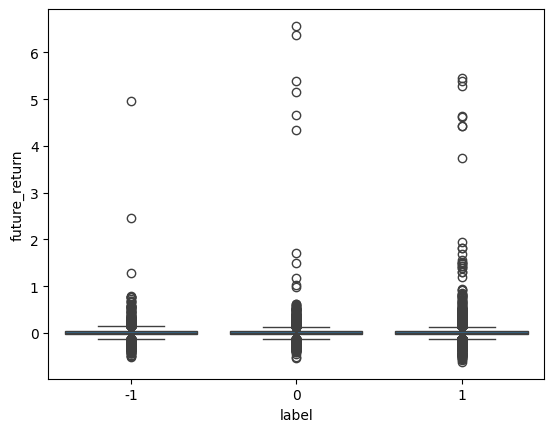

In [64]:
# verify direction
sns.boxplot(data=df_labeled, x='label', y='future_return')


That’s a very healthy label distribution — nearly balanced, with only a mild bullish skew.

Let’s interpret it precisely:

Label	Meaning	Proportion	Comment
+1	Bullish (buy signal)	40.1%	Slightly dominant — suggests the rule set tends to favor upward conditions (typical for equities and trending assets).
0	Neutral / no clear signal	30.2%	Good — not overfitting noise. Roughly one-third of the time the system abstains from making a call, which usually improves robustness.
–1	Bearish (sell signal)	29.7%	Almost symmetric with +1 — nice balance.

In [65]:
df_labeled.groupby('label')['future_return'].mean()
df_labeled.groupby("Ticker").head(1)

Price                    Open        High         Low       Close    Volume  \
Date       Ticker                                                             
2015-02-13 AMZN     18.920500   19.150000   18.850500   19.091499  69502000   
           AVGO      8.324790    8.339927    8.180242    8.336143  14614000   
           CYBR     53.840000   55.400002   52.299999   52.520000   7197200   
           CYTK      7.430000    7.950000    7.340000    7.780000   2173700   
           ETN      55.210896   56.043339   55.072156   55.920017   3118800   
           LIN     103.062038  104.277434  102.930641  104.203522    770200   
           LLY      58.493584   58.659075   58.079851   58.386009   2691900   
           LQD      83.803417   83.851782   83.478677   83.485588   2068700   
           META     75.991530   76.011411   75.037413   75.275940  18621900   
           SLNO    124.500000  138.000000  118.500000  132.750000       111   
           SPY     174.125308  174.766598  173.867112  174.716629  93670400   
           TLT      97.307420   97.322450   96.240504   96.315643   8325200   
           VNQ      55.995070   56.021145   55.121570   55.447502   3444500   
           WM       41.754496   41.794958   41.001943   41.503647   4966300   
           XLV      59.095704   59.338828   58.827430   59.288528   8592300   

Price               returns  logReturns  Volatility      Range      Body  ...  \
Date       Ticker                                                         ...   
2015-02-13 AMZN    0.012355    0.012279    0.011671   0.299500  0.171000  ...   
           AVGO    0.004102    0.004093    0.019209   0.159685  0.011352  ...   
           CYBR    0.149486    0.139315    0.063577   3.100002  1.320000  ...   
           CYTK    0.198767    0.181294    0.071137   0.610000  0.350000  ...   
           ETN     0.012561    0.012483    0.027076   0.971183  0.709121  ...   
           LIN     0.012205    0.012131    0.007954   1.346793  1.141483  ...   
           LLY     0.000425    0.000425    0.010886   0.579224  0.107575  ...   
           LQD    -0.003957   -0.003965    0.004330   0.373105  0.317829  ...   
           META   -0.006428   -0.006449    0.009876   0.973999  0.715590  ...   
           SLNO    0.066265    0.064162    0.091411  19.500000  8.250000  ...   
           SPY     0.004117    0.004108    0.007236   0.899487  0.591321  ...   
           TLT    -0.010268   -0.010322    0.007810   1.081947  0.991777  ...   
           VNQ    -0.006657   -0.006679    0.012089   0.899575  0.547568  ...   
           WM     -0.026755   -0.027120    0.010465   0.793014  0.250849  ...   
           XLV     0.003975    0.003967    0.010584   0.511398  0.192825  ...   

Price              MACD_Signal     BB_High      BB_Low        ATR         OBV  \
Date       Ticker                                                               
2015-02-13 AMZN       0.742694   20.424310   13.602739   0.483210  1240280000   
           AVGO       0.070747    8.308047    7.665038   0.245646   128642000   
           CYBR       1.879227   46.498568   28.586932   2.818219    14948400   
           CYTK      -0.154799    8.005182    6.029818   0.542042     5373000   
           ETN        1.022278   56.447611   47.606046   1.268430     8917400   
           LIN        0.163203  104.889096   99.191819   1.581660   -10462100   
           LLY       -0.115070   59.874147   57.260022   1.038329   -23486100   
           LQD       -0.122627   85.416372   83.025979   0.459386    25930400   
           META      -0.206701   77.640191   73.555732   1.578539   -23048000   
           SLNO       3.463089  144.743443   87.051556  15.202527        1062   
           SPY        0.968061  174.651650  165.750917   2.206119  -167372500   
           TLT       -0.761404  104.130121   96.151257   1.376528     4821400   
           VNQ       -0.270284   58.276414   54.800415   0.825740    32707800   
           WM         0.012671   43.292516   41.630144   0.5884

In [66]:
df_labeled.columns.name = "Features"
print(df_labeled.columns)



Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return',
       'label', 'vote_total'],
      dtype='object', name='Features')


In [67]:

def backtest_vs_market(df, label_col="label", return_col="returns", ticker_col="Ticker", date_col="Date"):
    """
    Backtests strategy per ticker and compares it to actual market performance.
    Prints a summary and generates a separate plot for each ticker.
    """
    df_copy = df.reset_index().copy()
    df_copy.sort_values([ticker_col, date_col], inplace=True)

    tickers = df_copy[ticker_col].unique()

    for ticker in tickers:
        df_t = df_copy[df_copy[ticker_col] == ticker].copy()

        # Strategy logic
        df_t["position"] = df_t[label_col].shift(1)
        df_t["strategy_returns"] = df_t["position"] * df_t[return_col]
        df_t["strategy_returns"] = df_t["strategy_returns"].fillna(0)
        df_t['strategy_returns'].plot(title=f"Strategy Returns – {ticker}")
        


        # Cumulative returns
        df_t["cumulative_market"] = (1 + df_t[return_col]).cumprod()
        df_t["cumulative_strategy"] = (1 + df_t["strategy_returns"]).cumprod()

        # Metrics
        strategy_return = df_t["cumulative_strategy"].iloc[-1] - 1
        market_return = df_t["cumulative_market"].iloc[-1] - 1
        hit_rate = (df_t["strategy_returns"] > 0).mean()

        # Print summary
        print(f"\n📈 Ticker: {ticker}")
        print(f"Strategy Total Return: {strategy_return:.2%}")
        print(f"Market Total Return:   {market_return:.2%}")
        print(f"Hit Rate:              {hit_rate:.2%}")
        
        # print(f"\n{ticker} – Last 5 strategy returns:")
        # print(df_t[['Date', 'label', 'position', 'strategy_returns']].tail())
        # print(df_t[['ATR', 'label']].tail(10))


        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df_t[date_col], df_t["cumulative_market"], linestyle="--", label="Market", color="gray")
        plt.plot(df_t[date_col], df_t["cumulative_strategy"], label="Strategy", color="blue")
        plt.title(f"Cumulative Returns – {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



In [68]:
# backtest_vs_market(df_labeled)

### Issues
1. Signal flatlining examples

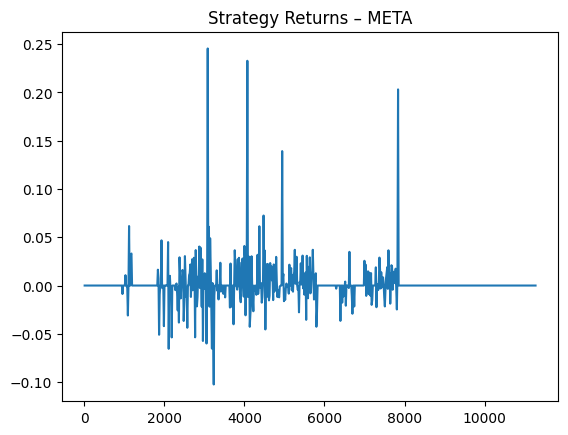

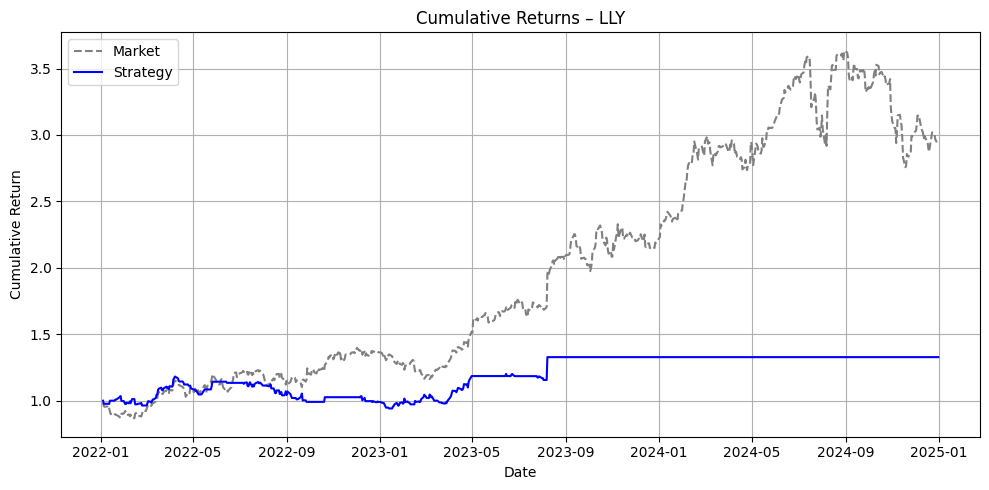


This was not a computational bug, but a signal silence issue. When the rulebase is voting neutral for consecutive days the strategy is deliberately abstaining from trading. Not inherently bad but could mean the volatility filter is overly active, votethreshold too strict or potentially indicators are cancelling eachother out. Further diagnostics revealed that the volatiliy gating logic is suppressing signals during periods of elevated ATR, causing a persistent label==0 and flatlining of strategy returns. 

(  # Volatility filter (neutralize extreme noise)
    high_vol = df['ATR'] > df['ATR'].quantile(0.9))

This logic means that any time ATR exceeds the 90th percentile, we force the label to 0 regardless of vote strength. This is a hard gate — and while it protects against noise, it can also suppress valid signals during high-volatility breakouts. Hard gating these events in the labeled data will prevent the model from learning how to trade in all types of regimes including volatile ones. This in turn will cause the model to underperform in real-time if volatility spikes and no fallback logic is present.

this is a real issue in indicator ensemble systems: volatility filters (like ATR > 90th percentile) are great for preventing false breakouts, but they can “hard-freeze” the model in prolonged volatile regimes (like macro shocks or crypto rallies), causing the signal to flatline to 0 when the system should actually be adaptive.

Solution -> Soft gating mechanism: Instead of forcing the label to 0 if High_vol is True we scale down the vote intensity based on how high the volatitility is, allowing the model to stay cautiously responsive. 

2. Poor directional Separability
label
- -1    -> 0.011829 # supposed to be bearish but paradoxically the most positive
-   0    -> 0.003907 # Neutral but not much lower than Long signal
-   1    -> 0.004475 # Long signal barely better than neutral

Suggests the labeling logic is not capturing directional edge. Worse the short-label is actually  misalliged, showing positve forward returns. 

Implications for EA training
EA depends on fitness landscape contrast — differences in future returns between labels.
Current labels do not provide a strong directional gradient.
Training a classifier to match labels may succeed (it can mimic your voting logic), but it won’t yield profitable strategies because the labels don’t correlate with future returns.

Solution -> Increase separability through practical steps

- Shift indicators by 1–2 bars to avoid lookahead bias.
- Reduce the vote thresholds and re-examine label–future_return correlation.
- Add fallback strength as a soft vote, not hard +1/–1.
- Evaluate labels:
- shorten the SMA/EMA lookback windows from 50/20 to 20/10 may make trend indicators more responsive 
- Add reversal aware rules -> bearish engulfing candle and RSI divergence.
- Strengthen Wick exhaustion
- Add return based label correction # makes it partially hind-sight aware but suppresses misaligned signals

The opportunity we’ve created here, by curating a dataset with high label purity and directional alignment, we've laid the groundwork for a model to learn:

- Temporal dynamics: How momentum, volatility, and volume interact over time.
- Cross-indicator synergies: For example, how MACD + RSI + OBV behave together in different regimes.
- Volatility-aware signal weighting: Learning when to trust certain features more or less.
- Reversal vs trend continuation: Differentiating between early reversals and trend confirmations.

🔍 Predict Future Returns More Effectively
Even though the labels are curated with hindsight, the model itself will only see past features at inference time. So if trained properly:
- It can generalize from clean directional examples.
- It can learn to approximate the logic that led to those labels — without needing future returns.
- It can outperform naive baselines by capturing nonlinear, regime-aware patterns that your rule base only partially encodes.

new separatability: 
label
- -1   -0.034429
-  0    0.003487
-  1    0.039256

Meaningful Separability

The mean separability values (-0.034, 0.003, 0.039) indicate mild but directionally consistent differences in returns per label.
That’s expected for rule-based signals, subtle but coherent edges. This is ideal for evolution: not feeding it hindsight-perfect data, but a signal-rich prior.

### Conlusion

We've done the hard part: building a thoughtful, interpretable rule-based signal engine and rigorously backtested it across tickers.
In this section we've
- modularized indicators across trend, momentum, volume, and volatility.
- weighted rules by reliability and tuned thresholds to balance precision and coverage.
- benchmarked strategy vs market returns, hit rates, and identified asset-specific strengths and weaknesses.
- diagnosed flatlining, overfitting, and regime sensitivity — and built in volatility gating.




# Normalization

In [69]:
# generate the Realistic model and the hindsight adjusted model
labeled_adjusted = label_data_adjusted(df_processed)
labeled_realistic = label_data(df_processed)

In [70]:
labeled_realistic["StochRSI"]

Date        Ticker
2015-02-13  AMZN      0.974096
            AVGO      1.000000
            CYBR      1.000000
            CYTK      1.000000
            ETN       1.000000
                        ...   
2024-12-31  SPY       0.148144
            TLT       0.215559
            VNQ       0.807001
            WM        0.036249
            XLV       0.740162
Name: StochRSI, Length: 37155, dtype: float64

In [71]:
# check label distribution and separability
print("Hindsight adjusted numbers")
print(labeled_adjusted["label"].value_counts(normalize=True))
print(labeled_adjusted.groupby('label')['future_return'].mean())
print("\n")

# check label distribution and separability for the realistic dataset
print("Realistic strategy")
print(labeled_realistic["label"].value_counts(normalize=True))
print(labeled_realistic.groupby('label')['future_return'].mean())

labeled_realistic.columns

Hindsight adjusted numbers
label
 0    0.567407
 1    0.299045
-1    0.133549
Name: proportion, dtype: float64
label
-1   -0.054776
 0    0.003266
 1    0.060985
Name: future_return, dtype: float64


Realistic strategy
label
 1    0.513928
-1    0.318369
 0    0.167703
Name: proportion, dtype: float64
label
-1    0.009124
 0    0.017111
 1    0.013762
Name: future_return, dtype: float64


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return',
       'label', 'vote_total'],
      dtype='object', name='Price')

In [72]:
def zscore_per_ticker(df, feature_col, ticker_col='Ticker', window=None):
    def compute_z(x):
        if window:
            mean = x.rolling(window).mean()
            std = x.rolling(window).std()
        else:
            mean = x.mean()
            std = x.std()
        return (x - mean) / std

    return df.groupby(ticker_col)[feature_col].transform(compute_z)

In [73]:
# compute z-score per ticker for both sets
labeled_adjusted['z_volatility'] = zscore_per_ticker(labeled_adjusted, 'Volatility', window=20)
labeled_adjusted['z_returns'] = zscore_per_ticker(labeled_adjusted, 'returns')

labeled_realistic['z_volatility'] = zscore_per_ticker(labeled_realistic, 'Volatility', window=20)
labeled_realistic['z_returns'] = zscore_per_ticker(labeled_realistic, 'returns')

In [74]:
labeled_realistic = labeled_realistic.dropna().copy()

In [75]:
print(type(labeled_adjusted))
print(labeled_adjusted.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns', 'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return', 'label', 'vote_total', 'z_volatility', 'z_returns']


In [76]:
labeled_adjusted_spy = labeled_adjusted[labeled_adjusted.index.get_level_values('Ticker') == 'CYBR'].reset_index()
labeled_adjusted_spy.describe()


Price,Date,Open,High,Low,Close,Volume,returns,logReturns,Volatility,Range,...,BB_Low,ATR,OBV,OBV_prev,CMF,future_return,label,vote_total,z_volatility,z_returns
count,2477,2477.000000,2477.000000,2477.000000,2477.000000,2.477000e+03,2477.000000,2477.000000,2477.000000,2477.000000,...,2477.000000,2477.000000,2.477000e+03,2.477000e+03,2477.000000,2472.000000,2477.000000,2477.000000,2458.000000,2.477000e+03
mean,2020-01-14 14:20:58.619297536,115.552394,117.558449,113.458272,115.558995,7.016507e+05,0.001217,0.000804,0.025612,4.100177,...,104.722626,4.319361,4.182027e+07,4.178677e+07,0.023855,0.015096,0.211143,2.375212,0.047756,-6.454264e-18
min,2015-02-13 00:00:00,32.400002,34.490002,31.500000,32.779999,1.034000e+05,-0.169581,-0.185824,0.004347,0.399998,...,20.235943,0.803731,1.587100e+06,1.587100e+06,-0.389449,-0.386230,-1.000000,-14.700000,-3.180096,-5.940980e+00
25%,2017-07-31 00:00:00,53.020000,53.880001,52.220001,53.060001,3.473000e+05,-0.012287,-0.012364,0.015862,1.849998,...,48.965924,2.006773,1.942600e+07,1.939510e+07,-0.083112,-0.043148,0.000000,-5.100000,-0.978609,-4.697253e-01
50%,2020-01-15 00:00:00,111.730003,113.459999,109.430000,111.589996,4.872000e+05,0.001358,0.001358,0.022656,3.459999,...,98.968978,4.016755,4.854020e+07,4.853330e+07,0.021221,0.017889,0.000000,5.500000,-0.096339,4.932481e-03
75%,2022-06-30 00:00:00,150.929993,153.925003,147.880005,150.679993,7.533000e+05,0.014662,0.014555,0.031681,5.439987,...,136.634901,6.129608,5.800390e+07,5.800380e+07,0.125047,0.075752,1.000000,8.900000,1.071714,4.676659e-01
max,2024-12-31 00:00:00,329.149994,336.839996,327.399994,333.149994,1.198640e+07,0.204677,0.186211,0.095111,26.959991,...,309.132227,11.308103,9.152820e+07,9.152820e+07,0.448647,0.479355,1.000000,14.100000,4.081751,7.077121e+00
std,NaN,66.698905,67.638228,65.648867,66.694581,7.695434e+05,0.028749,0.028727,0.013573,3.062450,...,61.273431,2.389861,2.311712e+07,2.310633e+07,0.153093,0.099020,0.631872,7.800656,1.266735,1.000000e+00


In [77]:
labeled_adjusted["RSI"].head(30)

Date        Ticker
2015-02-13  AMZN      82.272892
            AVGO      64.363626
            CYBR      82.776117
            CYTK      61.349174
            ETN       68.278374
            LIN       57.100254
            LLY       51.967012
            LQD       43.663173
            META      47.101490
            SLNO      59.069868
            SPY       63.366055
            TLT       36.401578
            VNQ       45.951053
            WM        38.206854
            XLV       55.782466
2015-02-17  AMZN      74.632574
            AVGO      65.693200
            CYBR      86.766292
            CYTK      65.434294
            ETN       66.027497
            LIN       59.028488
            LLY       58.392981
            LQD       38.980651
            META      46.357254
            SLNO      75.585728
            SPY       64.007327
            TLT       31.754341
            VNQ       44.796167
            WM        62.905104
            XLV       58.827489
Name: RSI, dtype: flo

In [78]:
# Normalizing the adjusted dataset
cols_to_normalize = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'logReturns',
    'Range', 'Body', 'Wick', 'ATR', 'MACD', 'MACD_Signal',
    'OBV', 'OBV_prev', 'CMF',
    'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30',
    'BB_High', 'BB_Low'
]

for col in cols_to_normalize:
    labeled_adjusted[f'z_{col}'] = zscore_per_ticker(labeled_adjusted, feature_col=col)


In [79]:
# Normalizing the realistic dataset
cols_to_normalize = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'logReturns',
    'Range', 'Body', 'Wick', 'ATR', 'MACD', 'MACD_Signal',
    'OBV', 'OBV_prev', 'CMF',
    'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30',
    'BB_High', 'BB_Low'
]

for col in cols_to_normalize:
    labeled_realistic[f'z_{col}'] = zscore_per_ticker(labeled_realistic, feature_col=col)


# Validate Normalized datasets

array([[<Axes: title={'center': 'z_volatility'}>,
        <Axes: title={'center': 'z_returns'}>,
        <Axes: title={'center': 'z_Open'}>,
        <Axes: title={'center': 'z_High'}>,
        <Axes: title={'center': 'z_Low'}>],
       [<Axes: title={'center': 'z_Close'}>,
        <Axes: title={'center': 'z_Volume'}>,
        <Axes: title={'center': 'z_logReturns'}>,
        <Axes: title={'center': 'z_Range'}>,
        <Axes: title={'center': 'z_Body'}>],
       [<Axes: title={'center': 'z_Wick'}>,
        <Axes: title={'center': 'z_ATR'}>,
        <Axes: title={'center': 'z_MACD'}>,
        <Axes: title={'center': 'z_MACD_Signal'}>,
        <Axes: title={'center': 'z_OBV'}>],
       [<Axes: title={'center': 'z_OBV_prev'}>,
        <Axes: title={'center': 'z_CMF'}>,
        <Axes: title={'center': 'z_SMA_10'}>,
        <Axes: title={'center': 'z_EMA_10'}>,
        <Axes: title={'center': 'z_SMA_20'}>],
       [<Axes: title={'center': 'z_EMA_20'}>,
        <Axes: title={'center': 'z_SMA

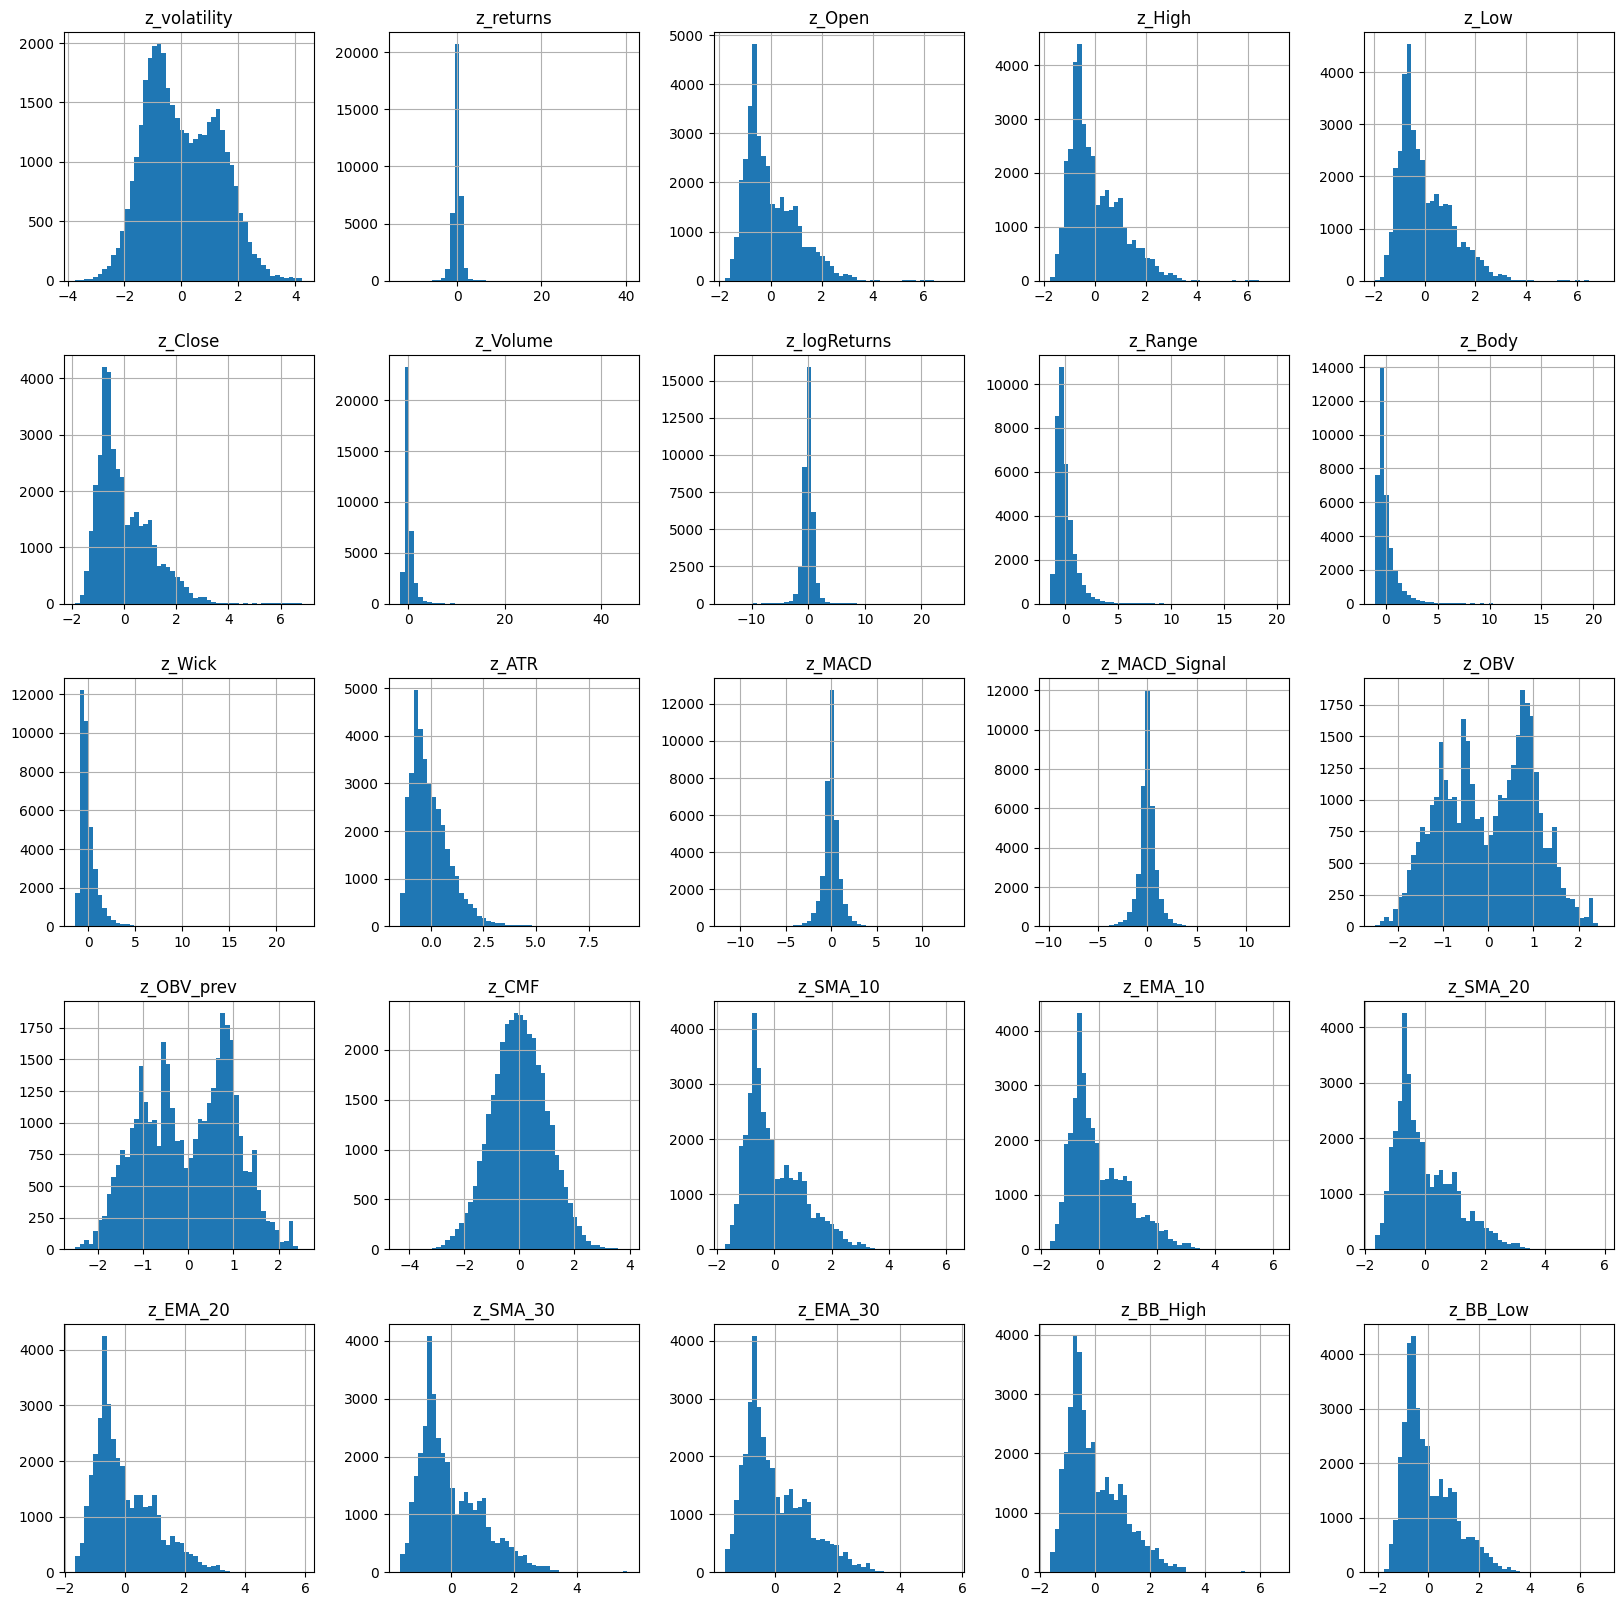

In [80]:
# Hist of normalized features
labeled_realistic[[col for col in labeled_realistic.columns if col.startswith('z_')]].hist(figsize=(20, 20), bins=50)

- Mean ≈ 0
- Std ≈ 1
- No extreme skew or flat distributions
- No NaNs or constant values

---

2. Verify Per-Ticker Normalization
Since we normalize per ticker, confirm that each ticker’s normalized features are centered

In [81]:
labeled_realistic.groupby('Ticker')[[col for col in labeled_realistic.columns if col.startswith('z_')]].mean()


Price,z_volatility,z_returns,z_Open,z_High,z_Low,z_Close,z_Volume,z_logReturns,z_Range,z_Body,...,z_OBV_prev,z_CMF,z_SMA_10,z_EMA_10,z_SMA_20,z_EMA_20,z_SMA_30,z_EMA_30,z_BB_High,z_BB_Low
Ticker,,,,,,,,,,,,,,,,,,,,,
AMZN,0.070143,0.001194,-2.172471e-17,1.955224e-17,-1.249171e-16,-4.924267e-17,1.117917e-16,2.127211e-18,-2.498341e-17,-3.647940e-17,...,1.269990e-16,4.195584e-17,-1.832117e-16,-1.037355e-16,1.205721e-16,-1.571420e-16,6.770867e-17,-8.364012e-17,7.241569e-19,2.597008e-16
AVGO,-0.008206,-0.002018,-7.241569e-19,-4.399253e-17,-3.276810e-17,-8.146765e-17,-5.913194e-17,-2.172471e-18,-6.988114e-17,-7.698693e-17,...,5.014786e-17,-6.624904e-17,-5.974294e-18,-5.847567e-17,9.957157e-17,-1.540644e-16,-5.847567e-17,-5.847567e-17,-2.100055e-16,-1.432020e-16
CYBR,0.048081,-0.002708,-3.059563e-17,1.122443e-17,8.110557e-17,-7.657959e-17,-3.156871e-17,1.369109e-17,-7.965726e-18,5.847567e-17,...,5.829463e-17,7.852576e-18,2.583430e-16,-2.588861e-16,3.457849e-17,-6.788971e-17,3.698631e-16,1.665561e-17,-2.192385e-16,7.151049e-17
CYTK,0.046349,-0.001391,-7.965726e-18,-2.860420e-17,-9.839482e-17,-7.739427e-17,1.458709e-17,1.425684e-18,-7.299275e-17,5.984478e-17,...,-4.480721e-17,-1.384950e-17,3.258706e-17,-1.203911e-16,-5.919983e-17,-2.172471e-17,7.974778e-17,2.549032e-16,-5.729891e-17,-5.295397e-17
ETN,0.014697,0.002164,1.325207e-16,-1.129685e-16,-1.236498e-16,8.526947e-17,1.613413e-16,5.883775e-18,-1.408485e-16,3.168186e-17,...,-1.710821e-17,2.242623e-17,1.285378e-17,-8.345908e-17,6.951906e-17,-1.392192e-16,-4.833747e-17,2.248507e-16,5.413073e-17,8.870922e-17
LIN,0.029228,0.000471,3.258706e-18,-3.427978e-16,1.654698e-16,2.950939e-17,-4.299682e-17,-1.203911e-17,-1.050027e-16,4.082434e-17,...,-5.177722e-17,4.057542e-17,-1.499005e-16,1.649267e-16,-1.144168e-16,-3.365519e-16,-9.685598e-17,4.399253e-17,4.200110e-17,-1.792288e-17
LLY,0.026111,0.001668,2.869472e-16,-2.465754e-16,-1.495384e-16,5.503592e-17,4.073382e-18,-2.996199e-17,1.173134e-16,3.258706e-17,...,-5.069098e-17,2.149841e-18,6.137230e-17,2.534549e-18,1.513488e-16,1.355984e-16,-1.363225e-16,-9.214896e-17,-7.078634e-17,9.685598e-17
LQD,0.020673,0.000482,-1.751102e-16,7.523990e-16,1.827138e-16,4.146703e-16,-8.101505e-17,-8.689883e-18,9.346150e-18,2.195101e-18,...,-5.557904e-17,8.743629e-18,4.506519e-16,-1.060709e-15,-6.178416e-16,-1.081483e-15,-1.434736e-16,7.253789e-16,1.859273e-16,-5.883775e-19
META,0.067521,0.000241,-7.458816e-17,-1.097098e-16,-9.124377e-17,2.389718e-17,-7.526706e-17,6.472152e-18,1.670992e-16,-2.407822e-17,...,1.134211e-16,-3.217972e-17,-1.426589e-16,-1.515298e-16,9.233000e-17,-1.316155e-16,8.436428e-17,-5.974294e-17,4.578482e-16,-5.340657e-17


In [82]:
labeled_realistic[[col for col in labeled_realistic.columns if col.startswith('z_')] + ['future_return']].corr()['future_return'].sort_values(ascending=False)

Price
future_return    1.000000
z_OBV_prev       0.026963
z_OBV            0.026511
z_volatility     0.016848
z_Volume         0.005459
z_CMF           -0.003442
z_Wick          -0.009836
z_ATR           -0.010121
z_Body          -0.010673
z_Range         -0.011432
z_returns       -0.021448
z_logReturns    -0.024179
z_MACD_Signal   -0.024597
z_MACD          -0.028349
z_BB_High       -0.039071
z_SMA_30        -0.041368
z_SMA_20        -0.041708
z_EMA_30        -0.042014
z_EMA_20        -0.042734
z_SMA_10        -0.043546
z_EMA_10        -0.043977
z_BB_Low        -0.044259
z_Open          -0.045458
z_High          -0.045486
z_Low           -0.046465
z_Close         -0.046604
Name: future_return, dtype: float64

<Axes: xlabel='z_MACD', ylabel='future_return'>

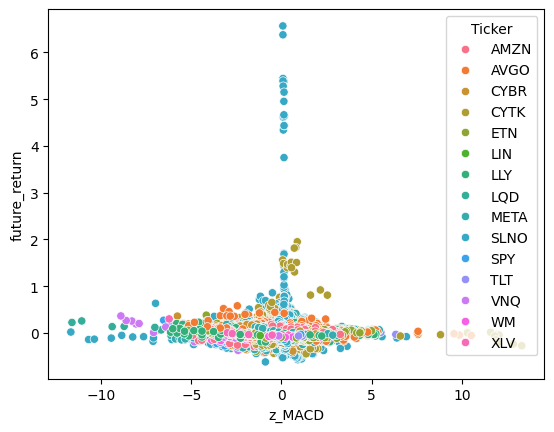

In [83]:
sns.scatterplot(data=labeled_realistic, x='z_MACD', y='future_return', hue='Ticker')


In [84]:
# No NaNS and 
labeled_realistic[[col for col in labeled_realistic.columns if col.startswith('z_')]].isna().mean().sort_values()

Price
z_volatility     0.0
z_returns        0.0
z_Open           0.0
z_High           0.0
z_Low            0.0
z_Close          0.0
z_Volume         0.0
z_logReturns     0.0
z_Range          0.0
z_Body           0.0
z_Wick           0.0
z_ATR            0.0
z_MACD           0.0
z_MACD_Signal    0.0
z_OBV            0.0
z_OBV_prev       0.0
z_CMF            0.0
z_SMA_10         0.0
z_EMA_10         0.0
z_SMA_20         0.0
z_EMA_20         0.0
z_SMA_30         0.0
z_EMA_30         0.0
z_BB_High        0.0
z_BB_Low         0.0
dtype: float64

In [85]:
# Enough unique values
labeled_realistic[[col for col in labeled_realistic.columns if col.startswith('z_')]].nunique().sort_values()

Price
z_Body           31241
z_Wick           32290
z_Range          32476
z_Close          33619
z_Open           34278
z_Low            34445
z_High           34495
z_Volume         35303
z_returns        36269
z_logReturns     36269
z_SMA_10         36584
z_SMA_20         36694
z_SMA_30         36707
z_BB_High        36746
z_BB_Low         36746
z_OBV            36766
z_OBV_prev       36766
z_MACD_Signal    36795
z_ATR            36795
z_volatility     36795
z_MACD           36795
z_EMA_10         36795
z_EMA_20         36795
z_CMF            36795
z_EMA_30         36795
dtype: int64

In [86]:
amzn = labeled_realistic.groupby(labeled_realistic.index.get_level_values('Ticker')).get_group('AMZN')
print(amzn[['MACD', 'z_MACD']].dropna().head())


Price                  MACD    z_MACD
Date       Ticker                    
2015-03-13 AMZN   -0.101142 -0.212526
2015-03-16 AMZN   -0.088010 -0.205054
2015-03-17 AMZN   -0.086591 -0.204247
2015-03-18 AMZN   -0.059189 -0.188657
2015-03-19 AMZN   -0.053567 -0.185459


<Axes: title={'center': 'Raw vs Normalized MACD'}>

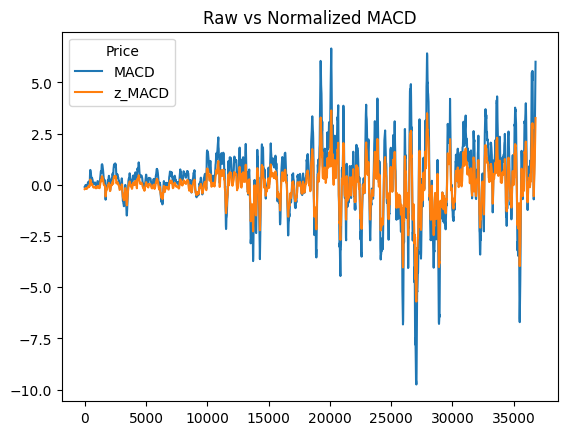

In [87]:
df_reset = labeled_realistic.reset_index()
df_reset[df_reset['Ticker'] == 'AMZN'][['MACD', 'z_MACD']].plot(title='Raw vs Normalized MACD')


In [88]:
def show_correlation(df, tickers):
    print("Tickers to proecess", tickers)
    for ticker in tickers:
        try:
            group = df.groupby(df.index.get_level_values('Ticker')).get_group(ticker)
            corr = group[['MACD', 'z_MACD']].corr().iloc[0, 1]
            print(f"Correlation between {ticker} MACD and z_MACD: {corr:.4f}")
        except KeyError:
            print(f"{ticker} not found in DataFrame.")
        except Exception as e:
            print(f"Error processing {ticker}: {e}")



In [89]:
# show_correlation(labeled_realistic, tickers)

In [90]:
def plot_all_tickers(df):
    df_reset = df.reset_index()
    n = len(tickers)

    # Create subplots grid
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 4 * n), sharex=True)

    # If only one ticker, axes won't be iterable
    if n == 1:
        axes = [axes]

    # Loop through tickers and plot on individual axes
    for i, ticker in enumerate(tickers):
        df_t = df_reset[df_reset['Ticker'] == ticker].dropna(subset=['MACD', 'z_MACD'])
        axes[i].plot(df_t['Date'], df_t['MACD'], label='MACD')
        axes[i].plot(df_t['Date'], df_t['z_MACD'], label='z_MACD')
        axes[i].set_title(f"{ticker} – Raw vs Normalized MACD")
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()


In [91]:
# plot_all_tickers(labeled_realistic)

In [92]:
def across_indicator_signal_response(df, target_ticker='AMZN'):
    df_reset = df.reset_index()
    df_reset['Ticker'] = df_reset['Ticker'].str.lower()
    target_ticker = target_ticker.lower()

    raw_vs_z_pairs = []
    for z_col in df.columns:
        if z_col.startswith('z_'):
            raw_candidate = z_col.replace('z_', '')
            # Find actual column name that matches case-insensitively
            raw_match = next((col for col in df.columns if col.lower() == raw_candidate.lower()), None)
            if raw_match:
                raw_vs_z_pairs.append((raw_match, z_col))


    for raw, z in raw_vs_z_pairs:
        df_t = df_reset[df_reset['Ticker'] == target_ticker].dropna(subset=[raw, z])
        if df_t.empty:
            continue
        df_t[[raw, z]].plot(title=f"{raw} vs {z} – {target_ticker.upper()}", figsize=(10, 4))
        plt.grid(True)
        plt.tight_layout()
        plt.show()



In [93]:
# across_indicator_signal_response(labeled_realistic)